# Implementation notes for lecture 3

Vibration equation

$$ 
\begin{equation}
u^{''} + \omega^2 u = 0, u(0)=I, u'(0) = 0 \label{eq:helmholtz}
\end{equation}
$$

Implementation

$$
\begin{align*}
  u^0 &= I\\
  u^{1} &= u^0 - \frac{1}{2}\Delta t^2 \omega^2 u^0 \\
  u^{n+1} &= 2u^n - u^{n-1} - \Delta t^2 \omega^2 u^{n}, n \in (1, 2, \ldots, N_t-1)
\end{align*}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Create solver

In [2]:
def solver(dt, T, w=0.35, I=1):
    """
    Solve Eq. (1)
    
    Parameters
    ----------
    dt : float
        Time step
    T : float
        End time
    I, w : float, optional
        Model parameters
    
    Returns
    -------
    t : array_like
        Discrete times (0, dt, 2*dt, ..., T)
    u : array_like
        The solution at discrete times t
    """
    dt = float(dt)
    Nt = int(round(T/dt))
    u = np.zeros(Nt+1)
    t = np.linspace(0, Nt*dt, Nt+1)
    u[0] = I
    u[1] = u[0] - 0.5*dt**2*w**2*u[0]
    for n in range(1, Nt):
        u[n+1] = 2*u[n] - u[n-1] - dt**2*w**2*u[n]
    return t, u

def u_exact(t, w=0.35, I=1):
    """Exact solution of Eq. (1)
    
    Parameters
    ----------
    t : array_like
        Array of times to compute the solution
    I, w : float, optional
        Model parameters
        
    Returns
    -------
    ue : array_like
        The solution at times t
    """
    return I*np.cos(w*t)


We now want to compute convergence rates. We will use the $\ell^2$-norm computed as 

$$E_i = \sqrt{\Delta t_i\sum_{n=0}^{N^{i}_t}(u^n-u_e(t_n))^2}$$

for a given uniform mesh level $i$. For example, we can use $N^0_t=8, N_t^{1}=16, N^2_t = 32$, etc., such that $\Delta t_{1} / \Delta t_2 = 2$ and $\Delta t_{n-1} / \Delta t_{n} = 2$ for all $n$. Note that there are $N_t^{i}$ intervals on level $i$ and $N_t^{i}+1$ points.

We assume that the error on the mesh with level $i$ can be written as 

$$E_i = C (\Delta t_i)^r, $$

where $C$ is a constant. This way, if we have the error on two levels, then we can compute

$$ \frac{E_{i-1}}{E_i} = \frac{ (\Delta t_{i-1})^r}{(\Delta t_{i})^r} = \left( \frac{\Delta t_{i-1}}{ \Delta t_i} \right)^r  $$

and isolate $r$ by computing

$$ r = \frac{\log {\frac{E_{i-1}}{E_i}}}{\log {\frac{\Delta t_{i-1}}{\Delta t_i}}} $$

So by computing the error on two different levels we can find the order of the convergence!

Let's first write a function that computes the $\ell^2$ error of the solver defined above

In [3]:
def l2_error(dt, T, w=0.35, I=0.3, sol=solver):
    """Compute the l2 error norm of result from `solver`
    
    Parameters
    ----------
    dt : float
        Time step
    T : float
        End time
    I, w : float, optional
        Model parameters
    sol : callable
        The function that solves Eq. (1)
        
    Returns
    -------
    float
        The l2 error norm 
    """
    t, u = sol(dt, T, w, I)
    ue = u_exact(t, w, I)
    return np.sqrt(dt*np.sum((ue-u)**2))

and then compute the convergence rates

In [4]:
def convergence_rates(m, dt0=30, num_periods=8, w=0.35, I=0.3, sol=solver):
    """
    Return m-1 empirical estimates of the convergence rate
    based on m simulations, where the time step is halved
    for each simulation.

    Parameters
    ----------
    m : int
        The number of mesh levels
    dt0 : int, optional
        Time steps per period on coarsest level
    num_periods : int, optional
        Size of domain is num_periods * 2pi / w
    w, I : float, optional
        Model parameters
    sol : callable
        The function that solves Eq. (1)
    
    Returns
    -------
    array_like
        The m-1 convergence rates
    array_like
        The m errors of the m meshes
    array_like
        The m time steps of the m meshes
        
    """
    P = 2*np.pi/w
    dt = P/dt0
    T = P*num_periods
    dt_values, E_values = [], []
    for i in range(m):
        E = l2_error(dt, T, w, I, sol=sol)
        dt_values.append(dt)
        E_values.append(E)
        dt = dt/2
    # Compute m-1 orders that should all be the same
    r = [np.log(E_values[i-1]/E_values[i])/
         np.log(dt_values[i-1]/dt_values[i])
         for i in range(1, m, 1)]
    return r, E_values, dt_values

Test it

In [5]:
convergence_rates(4)

([2.0036366687367093, 2.000949732819596, 2.000240106059534],
 [0.13526035155205302,
  0.033729955960525936,
  0.008426939670390836,
  0.0021063843253281167],
 [0.5983986006837702,
  0.2991993003418851,
  0.14959965017094254,
  0.07479982508547127])

These last two lists are the errors and timesteps af all the $m$ levels. We can plot the error as a function of timestep and show that the discretization scheme is second order.

ModuleNotFoundError: No module named 'plotslopes'

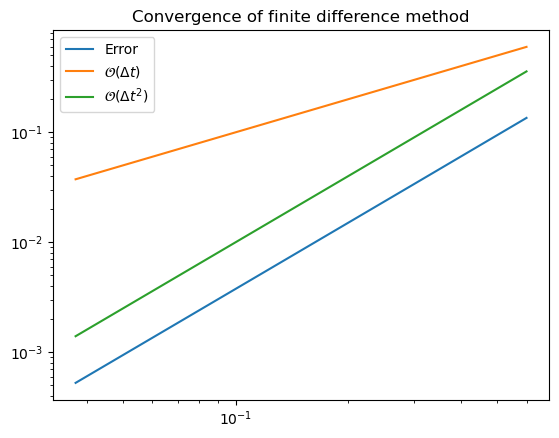

In [6]:
r, E, dt = convergence_rates(5)
plt.loglog(dt, E)
plt.loglog(dt, dt)
plt.loglog(dt, np.array(dt)**2)
plt.title('Convergence of finite difference method')
plt.legend(['Error', '$\mathcal{O}(\Delta t)$', '$\mathcal{O}(\Delta t^2)$'])
from plotslopes import slope_marker
slope_marker((dt[1], E[1]), (2,1))
slope_marker((dt[1], dt[1]), (1,1))
slope_marker((dt[1], dt[1]**2), (2,1))

We see that the error has the same slope as $\Delta t^2$.

We can write a test for the order of accuracy:

In [ ]:
def test_order(m):
    r, E, dt = convergence_rates(m)
    assert np.allclose(np.array(r), 2, atol=1e-2)

In [ ]:
test_order(5)

# Method of manufactured solution

Use a trivial solution to verify that the solver works.

Assume the solution is

$$ u(t) = t^2$$

The solution satisfies the boundary conditions (important): $u(0)=0$ and $u'(0)=0$. However

$$ u'' + \omega^2 u = 2 + \omega^2 t^2 \ne 0 $$

So we need to modify the source term of Eq. \eqref{eq:helmholtz}. Since in this case $u=t^2$ we get

$$
\begin{align*}
u'' + {\omega^2 u} &= 2 + \omega^2 u \\
u'' &= 2 \\
\end{align*}
$$

We also know that a second order accurate finite difference solution should be exact for a second order polynomial. Check:

In [ ]:
dt = 0.1
T = 10
Nt = int(round(T/dt))
t = np.linspace(0, Nt*dt, Nt+1)
u = t**2
uc = (u[2:] - 2*u[1:-1] + u[:-2])/dt**2
assert np.allclose(uc, 2)

The numerical solution is exact!

Assume now that the solution is

$$ u(t) = t^4 $$

Initial conditions still ok. Now the equation becomes

$$ 
\begin{align*}
u'' + \omega^2 u &= 12 t^2 + \omega^2 t^4 \\
u'' &= 12 t^2
\end{align*}
$$

Since the solution is a fourth order polynomial, the second order numerical solution will not be exact, but it will converge

In [ ]:
dt = 0.1
Nt = int(round(T/dt))
t = np.linspace(0, Nt*dt, Nt+1)
u = t**4
uc = (u[2:] - 2*u[1:-1] + u[:-2])/dt**2
print(uc-12*t[1:-1]**2)

Let's take a closer look at the numerical accuracy. The finite differece expression for $u''$ comes from two Taylor expansions around $t_n$

$$
\begin{align}
u^{n+1} &= u^n + \Delta t u' + \frac{\Delta t^2}{2}u'' + \frac{\Delta t^3}{6}u''' + \frac{\Delta t^4}{24}u'''' + \cdots \label{eq:T0} \\
u^{n-1} &= u^n - \Delta t u' + \frac{\Delta t^2}{2}u'' - \frac{\Delta t^3}{6}u''' + \frac{\Delta t^4}{24}u'''' + \cdots \label{eq:T1}
\end{align}
$$

Adding now \eqref{eq:T0} and \eqref{eq:T1} we get

$$
u^{n+1} - 2u^n + u^{n-1} = \Delta t^2 u'' + \frac{\Delta t^4}{12}u'''' + \cdots
$$

such that 

$$
u'' = \frac{u^{n+1} - 2u^n + u^{n-1}}{\Delta t^2} - \frac{\Delta t^2}{12}u'''' + \cdots
$$

There is a second order error proportional to $u''''$. For $u=t^2$ we have that $u''''=0$, and as such no numerical error for our scheme. For $u=t^4$ the numerical error is $2 \Delta t^2$

We can put the numerical expression into our equation and get

$$
\begin{align}
 u'' + \omega^2 u &= 0 \\
 \frac{u^{n+1} - 2u^n + u^{n-1}}{\Delta t^2} - \frac{\Delta t^2}{12}u'''' + \omega^2 u &= 0 \\
 \frac{u^{n+1} - 2u^n + u^{n-1}}{\Delta t^2} + \omega^2 u &= \frac{\Delta t^2}{12}u'''' 
\end{align}
$$

The residual is $\Delta t^2 u'''' / 12$.

Go back and check that the solution for $u=t^4$ correspond exactly to this residual:

In [ ]:
assert np.allclose(uc-12*t[1:-1]**2, 2*dt**2)

It is exact because the next error term will be proportional to the sixth derivative of $u$, which is zero for $u=t^4$.

# Adjusted solver

In [ ]:
def adj_solver(dt, T, w=0.35, I=1):
    """
    Solve Eq. (1)
    
    Parameters
    ----------
    dt : float
        Time step
    T : float
        End time
    I, w : float, optional
        Model parameters
    
    Returns
    -------
    t : array_like
        Discrete times (0, dt, 2*dt, ..., T)
    u : array_like
        The solution at discrete times t
    """
    dt = float(dt)
    Nt = int(round(T/dt))
    u = np.zeros(Nt+1)
    t = np.linspace(0, Nt*dt, Nt+1)
    u[0] = I
    u[1] = u[0] - 0.5*dt**2*(w*(1-w**2*dt**2/24))**2*u[0]
    for n in range(1, Nt):
        u[n+1] = 2*u[n] - u[n-1] - dt**2*(w*(1-w**2*dt**2/24))**2*u[n]
    return t, u


In [ ]:
r, E, dt = convergence_rates(5, sol=solver)
r2, E2, dt2 = convergence_rates(5, sol=adj_solver)
plt.loglog(dt, E)
plt.loglog(dt2, E2)
plt.loglog(dt, dt)
plt.loglog(dt, np.array(dt)**2)
plt.title('Convergence of finite difference method')
plt.legend(['Error', 'Error modified', '$\mathcal{O}(\Delta t)$', '$\mathcal{O}(\Delta t^2)$'])
from plotslopes import slope_marker
slope_marker((dt[1], E[1]), (2,1))
slope_marker((dt2[1], E2[1]), (4,1))
slope_marker((dt[1], dt[1]), (1,1))
slope_marker((dt[1], dt[1]**2), (2,1))